# Mantenimiento Predictivo - DATA PREPARATION
Según estas fuentes
https://docs.microsoft.com/en-us/azure/architecture/data-science-process/predictive-maintenance-playbook#summary<br>
https://github.com/Azure/AI-PredictiveMaintenance/blob/master/src/Notebooks/<br>
https://gallery.azure.ai/Experiment/Predictive-Maintenance-Step-1-of-3-data-preparation-and-feature-engineering-2<br>
Los datos deberían tener esta estructura:
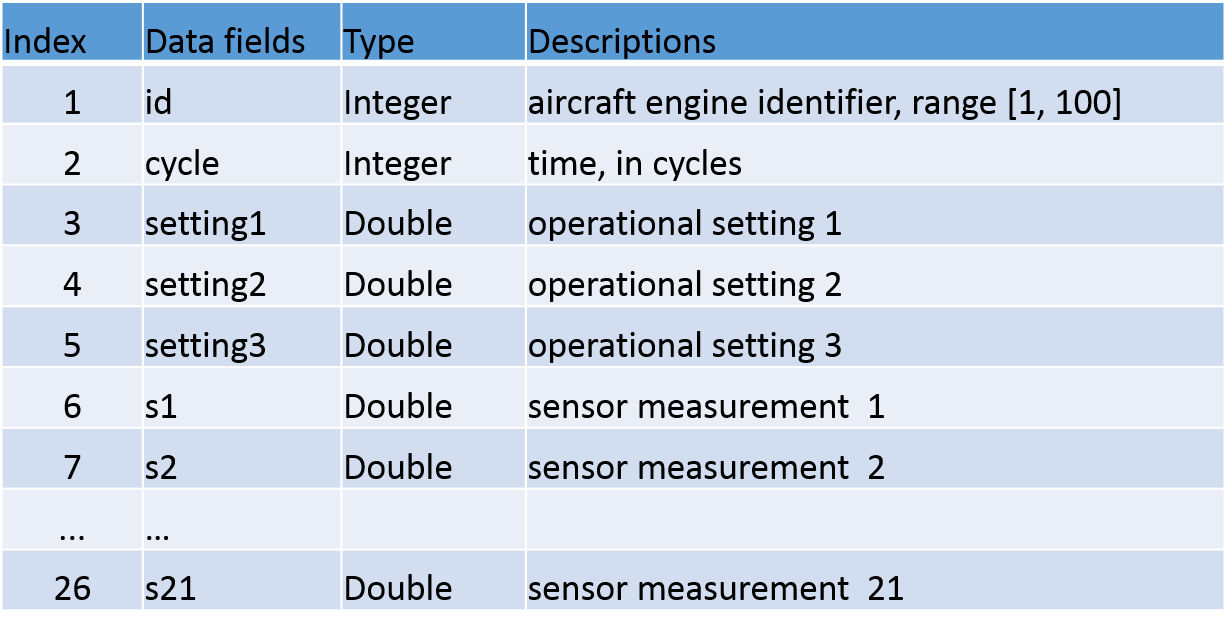

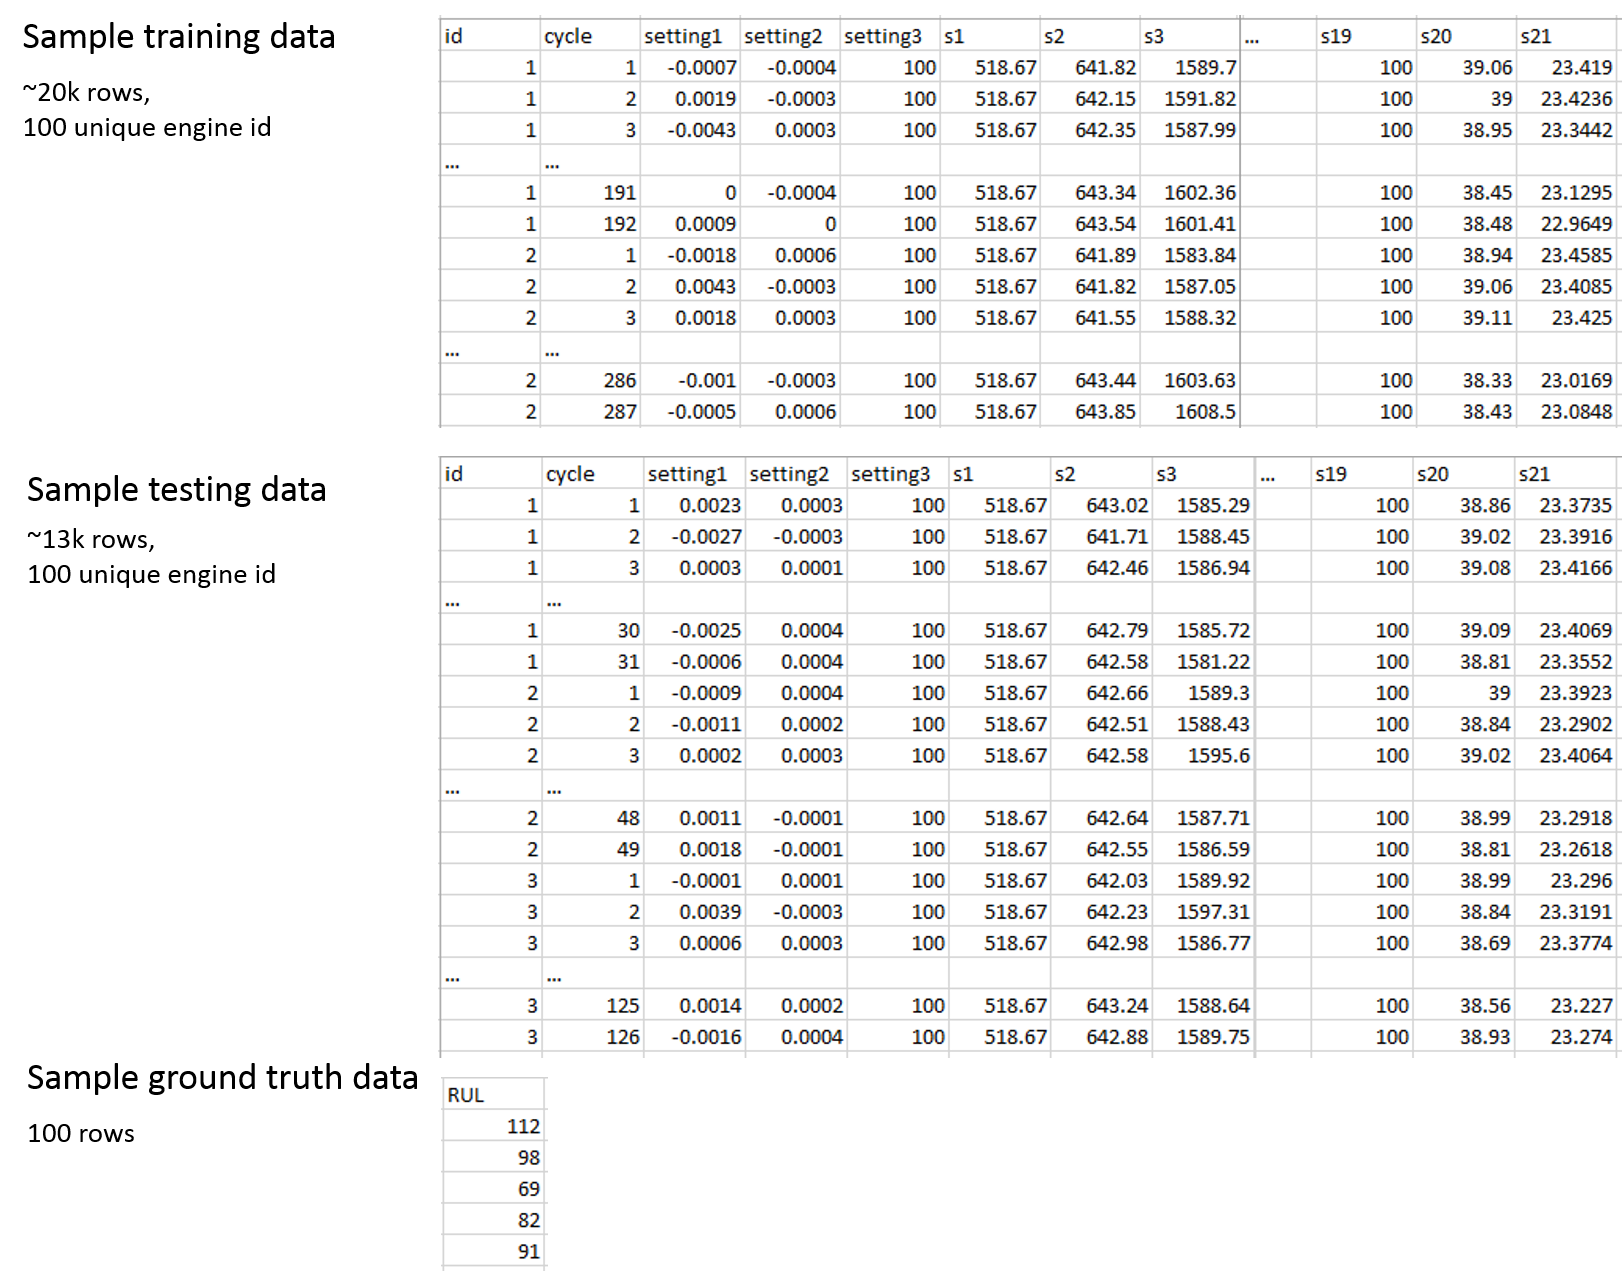


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import datetime

In [4]:
import re

In [5]:
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [6]:
# Seteos de Pandas para ver mejor la info. https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
# In max_columns and max_rows ‘None’ value means unlimited.
pd.set_option('display.max_rows', 100)
# Conviene setear min_rows también porque cuando se superan las max_rows, sólo muestra la cantidad indicada en min_rows.
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100
pd.options.display.float_format = '{:.1f}'.format

In [7]:
path_data = 'C:\\Users\\COLMO\\data_mining\\data_pampa'

In [8]:
file = 'EMA_compresores_5min.csv'

In [9]:
import locale
locale.getlocale()

('Spanish_Argentina', '1252')

In [10]:
# pd.read_csv()'http://files.grouplens.org/datasets/movielens/ml-100k/u.item', sep='|', names=m_cols, usecols=range(5), 
# encoding='windows-1251' o 'UTF-8')
df_comp = pd.read_csv(path_data + '\\' + file, sep=';', encoding='windows-1251').rename(columns={'Unnamed: 0': 'timestamp'})
df_comp.columns = df_comp.columns.str.lower()
df_comp.shape

(39503, 46)

In [11]:
# Estructura del nombre de tags esperada: K-01_COMP_RPM

In [12]:
# Necesito obtener el listado de compresores: splitteo por el caracter "_", tomo sólo el primer elemento splitteado, busco los uniques (set)
# convierto el set en lista:
element_lst = list(set([re.split("_", x)[0] for x in df_comp.columns[1:]]))
element_lst.sort() # Ordena in place y devuelve nan por eso se debe poner abajo que lo muestre.
element_lst

['k-01', 'k-02', 'k-03', 'k-04', 'k-05', 'k-06', 'k-07', 'k-08', 'k-09']

In [13]:
# Listado de tags
tag_lst = list(set([re.split("_", x, maxsplit=1)[1] for x in df_comp.columns[1:]]))
tag_lst

['presion_descarga 1y3',
 'comp_rpm',
 'em_carga_motriz',
 'presion_descarga 2y4',
 'presion_succion']

In [14]:
keys = [element_lst[0]+'_'+x for x in tag_lst]
values = [x for x in tag_lst]
dict(zip(keys, values))

{'k-01_presion_descarga 1y3': 'presion_descarga 1y3',
 'k-01_comp_rpm': 'comp_rpm',
 'k-01_em_carga_motriz': 'em_carga_motriz',
 'k-01_presion_descarga 2y4': 'presion_descarga 2y4',
 'k-01_presion_succion': 'presion_succion'}

In [15]:
print(element_lst[0]+'_'+tag_lst[0])
df_list = []
for element in element_lst:
    df_aux_columns = ['timestamp']
    for tag in tag_lst:
        df_aux_columns.append(element+'_'+tag)
    keys = [element+'_'+x for x in tag_lst]
    values = [x for x in tag_lst]
    rename_col_dict = dict(zip(keys, values))
    df_aux = df_comp[df_aux_columns].rename(columns=rename_col_dict)
    df_aux['element'] = element
    df_list.append(df_aux)
df_hist = pd.concat(df_list, ignore_index=True)
df_hist.tail()

k-01_presion_descarga 1y3


,timestamp,presion_descarga 1y3,comp_rpm,em_carga_motriz,presion_descarga 2y4,presion_succion,element
355522,15-ene-22 21:30:00,Comm Fail,Comm Fail,Comm Fail,Comm Fail,Comm Fail,k-09
355523,15-ene-22 21:35:00,Comm Fail,Comm Fail,Comm Fail,Comm Fail,Comm Fail,k-09
355524,15-ene-22 21:40:00,Comm Fail,Comm Fail,Comm Fail,Comm Fail,Comm Fail,k-09
355525,15-ene-22 21:45:00,Comm Fail,Comm Fail,Comm Fail,Comm Fail,Comm Fail,k-09
355526,15-ene-22 21:50:00,Comm Fail,Comm Fail,Comm Fail,Comm Fail,Comm Fail,k-09


In [16]:
# Se renombran columnas para facilidad de uso
df_hist.rename(columns={'presion_descarga 1y3': 'press_1', 'presion_succion': 'press_suc', 'presion_descarga 2y4': 'press_2', 
                       'comp_rpm': 'rpm', 'em_carga_motriz': 'carga_motriz'}, inplace=True)

In [17]:
# Correcciones de Tipo de Datos
#df_hist.timestamp.replace(r"\d{2}-ago-\d{4} \d{2}:\d{2}:\d{2}", r"\d{2}-aug-\d{4} \d{2}:\d{2}:\d{2}", inplace=True, regex=True)
#datetime.datetime.strptime('31-aug-21 18:00:00', '%d-%b-%y %H:%M:%S')
df_hist.timestamp = df_hist.timestamp.str.replace('ago', 'aug')
df_hist.timestamp = df_hist.timestamp.str.replace('ene', 'jan')
df_hist.timestamp = df_hist.timestamp.str.replace('abr', 'apr')
df_hist.timestamp = df_hist.timestamp.str.replace('ago', 'aug')
df_hist.timestamp = df_hist.timestamp.str.replace('dic', 'dec')
#df_hist.timestamp.astype('datetime64' , copy=False)
# https://docs.python.org/3.7/library/datetime.html#strftime-strptime-behavior
df_hist.timestamp = pd.to_datetime(df_hist.timestamp, dayfirst=True, format='%d-%b-%y %H:%M:%S')
df_hist.head()

,timestamp,press_1,rpm,carga_motriz,press_2,press_suc,element
0,2021-08-31 18:00:00,"89,3755722","1173,366211","97,75390625","90,52375793","34,26144409",k-01
1,2021-08-31 18:05:00,"89,3755722","1173,895508","97,02148438","90,31398773","34,26144409",k-01
2,2021-08-31 18:10:00,"89,3755722","1173,163452","96,77734375","90,31398773","34,26144409",k-01
3,2021-08-31 18:15:00,"89,15753937","1172,869263","97,65625","90,31398773","34,26144409",k-01
4,2021-08-31 18:20:00,"88,22463989","1173,551025","96,875","89,5825882","34,26144409",k-01


In [18]:
df_hist.dtypes

timestamp       datetime64[ns]
press_1                 object
rpm                     object
carga_motriz            object
press_2                 object
press_suc               object
element                 object
dtype: object

In [19]:
# El .astype no reconoce como float a los strings con "," --> reemplazo por "."
# Los valores Bad, Comm Fail y I/O Timeout hay que convertirlos a numéricos. NO tengo claro cómo conviene "labelearlos", 
# por ahora, los convierto a un número negativo
for column in df_hist.columns[1:-1]:
    df_hist[column] = df_hist[column].str.replace(',', '.')
    df_hist[column] = df_hist[column].str.replace('Bad', '-1')
    df_hist[column] = df_hist[column].str.replace('Comm Fail', '-2')
    df_hist[column] = df_hist[column].str.replace('I/O Timeout', '-3')
    df_hist[column] = df_hist[column].astype('float64' , copy=True)
print(df_hist.dtypes)
df_hist.head()

timestamp       datetime64[ns]
press_1                float64
rpm                    float64
carga_motriz           float64
press_2                float64
press_suc              float64
element                 object
dtype: object


,timestamp,press_1,rpm,carga_motriz,press_2,press_suc,element
0,2021-08-31 18:00:00,89.4,1173.4,97.8,90.5,34.3,k-01
1,2021-08-31 18:05:00,89.4,1173.9,97.0,90.3,34.3,k-01
2,2021-08-31 18:10:00,89.4,1173.2,96.8,90.3,34.3,k-01
3,2021-08-31 18:15:00,89.2,1172.9,97.7,90.3,34.3,k-01
4,2021-08-31 18:20:00,88.2,1173.6,96.9,89.6,34.3,k-01


In [20]:
# % Nulos
100*df_hist.isna().sum()/len(df_hist)

timestamp      0.0
press_1        0.0
rpm            0.0
carga_motriz   0.0
press_2        0.0
press_suc      0.0
element        0.0
dtype: float64

In [21]:
output_file = 'EMA_compresores_5min_ok.csv'
df_hist.to_csv(path_data + '\\' + output_file, sep=';', encoding='UTF-8', decimal = '.') #   'windows-1251'

In [22]:
file = 'EMA_compresores_diario_zafiro.csv'
# Bajada de SQL con estas columnas: 
# equipment_id, Equipo, Dia_Operativo, Comentarios, Estado, Mantenimiento_Programado, Mantenimiento_No_Programado, En_Reserva, En_Marcha,
# Rpm, facility_eqp_parameter_energy_generation, Presion_Succion, Presion_Descarga, Temperatura_Succion, Temperatura_Descarga, Caudal,
# es_overhaul
# Hay historia desde 2013 pero intermitente. Se recortan datos desde 2019-01 en adelante

In [23]:
# 'windows-1251' UTF-8 trae bien los caracteres especiales del castellano
df_diario = pd.read_csv(path_data + '\\' + file, sep=';', encoding='UTF-8', index_col=False,
                        names=['equipment_id', 'element', 'timestamp', 'comments', 'estado', 'mant_prog', 'mant_no_prog', 
                               'en_reserva', 'en_marcha', 'rpm', 'facility_eqp_parameter_energy_generation', 
                               'press_succ', 'press_desc', 'temp_succ', 'temp_desc', 'caudal', 'es_overhaul'])
df_diario = df_diario[(df_diario.element.str.lower().isin(element_lst)) & (df_diario.timestamp > '2019-01-01')]\
                            [['equipment_id', 'element', 'timestamp', 'comments', 
                               'estado', 'mant_prog', 'mant_no_prog', 'en_reserva', 'en_marcha', 'rpm', 
                               'press_succ', 'press_desc', 'temp_succ', 'temp_desc', 'caudal', 'es_overhaul']]
df_diario.shape

(10070, 16)

In [24]:
# timestamp
#print(pd.to_datetime('2021-08-15 00:00:00.000', dayfirst=True, format='%Y-%m-%d %H:%M:%S'))
df_diario.timestamp = pd.to_datetime(df_diario.timestamp, format='%Y-%m-%d %H:%M:%S')

In [25]:
# comments: 
print('Los comentarios Nan se convierten a Sin Novedades', df_diario.comments.isna().sum()) #2573
df_diario.comments.fillna('Sin Novedades', inplace=True)

Los comentarios Nan se convierten a Sin Novedades 7195


In [26]:
df_diario.dtypes

equipment_id             int64
element                 object
timestamp       datetime64[ns]
comments                object
estado                  object
mant_prog               object
mant_no_prog            object
en_reserva              object
en_marcha               object
rpm                     object
press_succ              object
press_desc              object
temp_succ               object
temp_desc               object
caudal                 float64
es_overhaul            float64
dtype: object

In [27]:
# Los datos tipo float vienen con ',' como separador decimal. Se reemplaza por '.' para poder convertir a float
# lista de campos tipo float:
columns = list(df_diario.columns[5:10]) + list(df_diario.columns[10:-2])
print(columns)
for column in columns:
    df_diario[column] = df_diario[column].str.replace(',', '.')
    df_diario[column] = df_diario[column].astype('float64' , copy=True)
print(df_diario.dtypes)
df_diario.head()

['mant_prog', 'mant_no_prog', 'en_reserva', 'en_marcha', 'rpm', 'press_succ', 'press_desc', 'temp_succ', 'temp_desc']
equipment_id             int64
element                 object
timestamp       datetime64[ns]
comments                object
estado                  object
mant_prog              float64
mant_no_prog           float64
en_reserva             float64
en_marcha              float64
rpm                    float64
press_succ             float64
press_desc             float64
temp_succ              float64
temp_desc              float64
caudal                 float64
es_overhaul            float64
dtype: object


,equipment_id,element,timestamp,comments,estado,mant_prog,mant_no_prog,en_reserva,en_marcha,rpm,press_succ,press_desc,temp_succ,temp_desc,caudal,es_overhaul
2009,25,K-01,2019-01-01,Sin Novedades,En Funcionamiento,NaN,NaN,NaN,NaN,1175.0,34.0,90.6,26.3,105.6,NaN,NaN
2010,25,K-01,2019-01-02,Sin Novedades,En Funcionamiento,NaN,NaN,NaN,NaN,1180.0,32.7,89.6,26.3,105.6,NaN,NaN
2011,25,K-01,2019-01-03,Sin Novedades,En Funcionamiento,NaN,NaN,NaN,NaN,1180.0,32.8,89.7,26.3,105.6,NaN,NaN
2012,25,K-01,2019-01-04,Sin Novedades,En Funcionamiento,NaN,NaN,NaN,NaN,1165.0,33.3,89.8,26.7,110.8,NaN,NaN
2013,25,K-01,2019-01-05,Sin Novedades,En Funcionamiento,NaN,NaN,NaN,NaN,1165.0,34.0,91.5,26.7,112.5,NaN,NaN


In [28]:
# % Nulos
100*df_diario.isna().sum()/len(df_diario)

equipment_id     0.0
element          0.0
timestamp        0.0
comments         0.0
estado           0.5
mant_prog       11.9
mant_no_prog    11.9
en_reserva      11.9
en_marcha       11.9
rpm              3.8
press_succ       3.8
press_desc       3.8
temp_succ        3.1
temp_desc        3.1
caudal         100.0
es_overhaul     95.0
dtype: float64

# Análisis Exploratorio de Datos

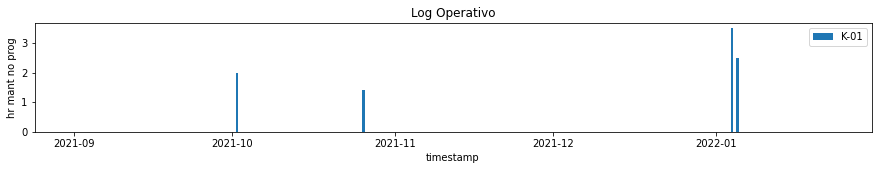

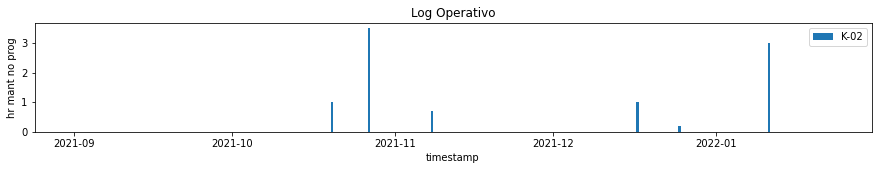

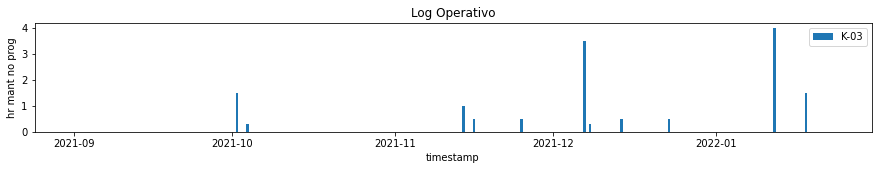

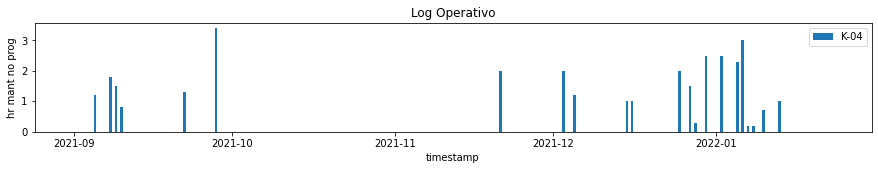

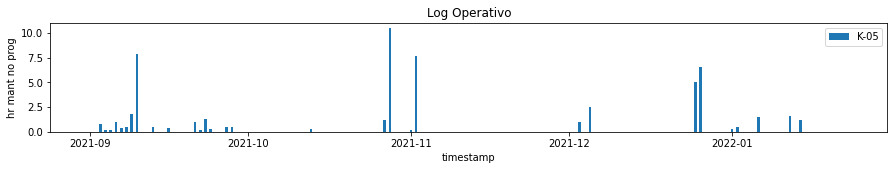

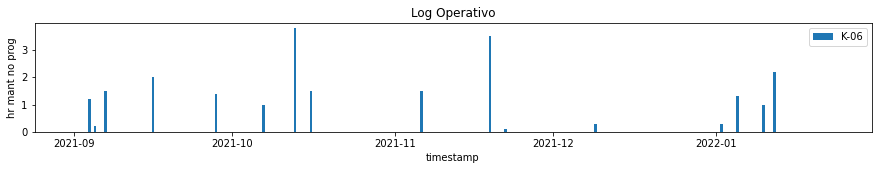

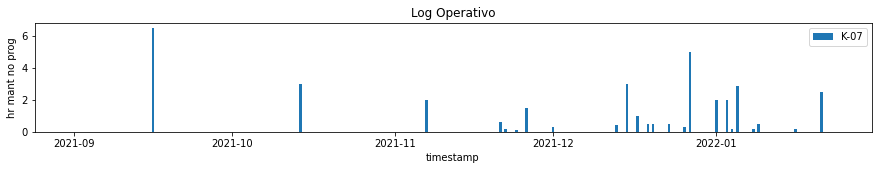

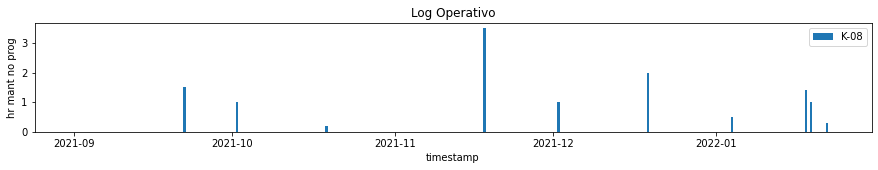

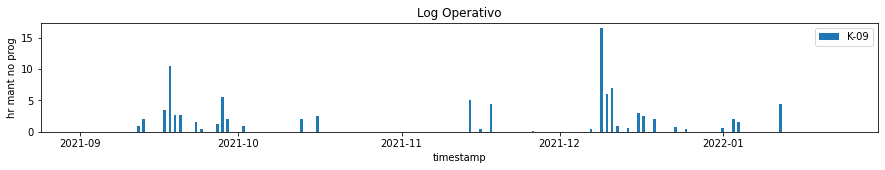

In [29]:
%matplotlib inline
width =0.5
for element in pd.unique(df_diario.element):
    plt.figure(figsize=(15, 2))
    plt.bar('timestamp', 'mant_no_prog', data=df_diario[(df_diario.element==element) & 
                                                    (df_diario.timestamp>='2021-09-01') & 
                                                    (df_diario.timestamp<'2022-02-01')], width=width, label=element)
    plt.xlabel('timestamp')
    plt.ylabel('hr mant no prog')
    plt.title('Log Operativo')
    plt.legend()
    plt.show()

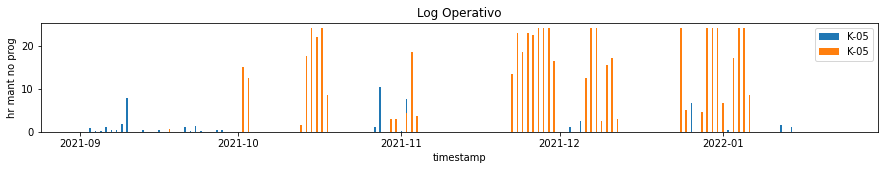

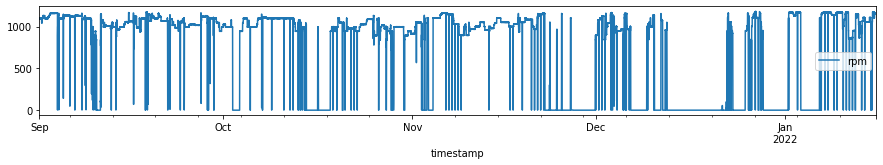

In [37]:
# OJO que los tiempos de rpm = 0 pueden ser por reserva:
plt.figure(figsize=(15, 2))
element='K-05'
plt.bar('timestamp', 'mant_no_prog', data=df_diario[(df_diario.element==element) & 
                                                    (df_diario.timestamp>='2021-09-01') & 
                                                    (df_diario.timestamp<'2022-02-01')], width=width, label=element)
plt.bar('timestamp', 'en_reserva', data=df_diario[(df_diario.element==element) & 
                                                    (df_diario.timestamp>='2021-09-01') & 
                                                    (df_diario.timestamp<'2022-02-01')], width=width, label=element)
plt.xlabel('timestamp')
plt.ylabel('hr mant no prog')
plt.title('Log Operativo')
plt.legend()
plt.show()
df_hist[(df_hist.element==element.lower()) & (df_hist.timestamp>='2021-09-01') & (df_hist.timestamp<'2022-02-01')]\
    [['element', 'timestamp', 'rpm']].plot(x='timestamp', figsize=(15, 2)); #, x_compat=True);

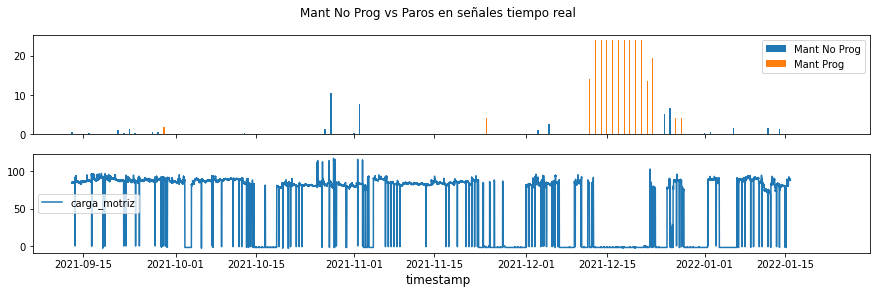

In [38]:
# O tiempos de rpm = 0 por mant programado:
#https://stackabuse.com/how-to-set-axis-range-xlim-ylim-in-matplotlib/
element='K-05'
f_desde = '2021-09-13'
f_hasta = '2022-02-01'
df_log = df_diario[(df_diario.element==element) & (df_diario.timestamp>=f_desde) & (df_diario.timestamp<f_hasta)]
df_rt = df_hist[(df_hist.element==element.lower()) & (df_hist.timestamp>=f_desde) & (df_hist.timestamp<f_hasta)]

width =0.3
fig, axs = plt.subplots(2, sharex=True, figsize=(15, 4))
fig.suptitle('Mant No Prog vs Paros en señales tiempo real')
fig.supxlabel('timestamp')
axs[0].bar('timestamp', 'mant_no_prog', data=df_log, width=width, label='Mant No Prog')
axs[0].bar('timestamp', 'mant_prog', data=df_log, width=width-0.1, label='Mant Prog')
axs[1].plot('timestamp', 'carga_motriz', data=df_rt)
for ax in fig.get_axes():
    ax.legend()
    ax.label_outer()

In [33]:
# Registros días con mant no programado y paro: 
df_log[(df_diario.mant_no_prog > 0)  & (df_diario.mant_prog == 0) &
       (df_diario.comments.str.contains('paro', case=False))][['element', 'timestamp', 'comments', 'mant_prog', 'mant_no_prog']]

,element,timestamp,comments,mant_prog,mant_no_prog
15215,K-05,2021-09-13,12:35 hs a 13:00 hs Paro de equipo por Shutdown desde ESM motor.-,0.0,0.5
15218,K-05,2021-09-16,paro desde ESM motor,0.0,0.4
15224,K-05,2021-09-22,09:00 hs a 09:50 hs Paro por baja velocidad ESM.-,0.0,0.2
15229,K-05,2021-09-27,"10:45 a 11:15 hs, Paro por Shutdown desde ESM Motor.",0.0,0.5
15230,K-05,2021-09-28,Paros por Shutdown desde ESM Motor.,0.0,0.5
15259,K-05,2021-10-27,17:30 hs a 18:45 hs Paro de equipo por ocilación de RPM y baja temp. En banco derecho.Mtto cambi...,0.0,1.2
15260,K-05,2021-10-28,"12:15 a 16:50 hs paro de equipo por baja Rpm y baja Temp en banco derecho, Mtto limpia fichas y ...",0.0,10.5
15264,K-05,2021-11-01,"16:15a 16:25hs, paro de equipo por sobrecarga y variacion de temp. De cil motor lado derecho.",0.0,0.2
15296,K-05,2021-12-03,Paro de equipo en 2 oportunidades por alta temperatura de cojinete motor # 3.-,0.0,1.0
15298,K-05,2021-12-05,paros varios alta temp. Coj.#3./Mtto. repara tubing de circ. aux. ref./ Mtto.Instr. cambia termo...,0.0,2.5


In [39]:
# El paro se vé cuando rpm y carga_motriz caen a 0. Pero ver fecha 2021-09-23: rpm en 0 por un mantenimiento programado -->
# Hay que linkear los datos del log con los de tiempo real.
df_rt[(df_rt.timestamp>='2021-09-23 16:00:00') & (df_rt.timestamp<='2021-09-23 18:00:00')]\
    [['element', 'timestamp', 'rpm', 'carga_motriz', 'press_1', 'press_2']]

,element,timestamp,rpm,carga_motriz,press_1,press_2
164612,k-05,2021-09-23 16:00:00,987.2,88.0,17.5,36.1
164613,k-05,2021-09-23 16:05:00,984.2,88.0,17.5,36.1
164614,k-05,2021-09-23 16:10:00,1018.4,88.3,17.7,35.3
164615,k-05,2021-09-23 16:15:00,1017.3,91.0,18.2,35.1
164616,k-05,2021-09-23 16:20:00,1018.3,90.4,18.2,35.1
164617,k-05,2021-09-23 16:25:00,1037.5,90.8,18.2,35.1
164618,k-05,2021-09-23 16:30:00,1075.0,94.3,18.4,35.7
164619,k-05,2021-09-23 16:35:00,1056.8,94.0,18.6,35.9
164620,k-05,2021-09-23 16:40:00,1058.4,94.9,18.9,35.9
164621,k-05,2021-09-23 16:45:00,1058.0,94.7,18.9,35.9


In [104]:
# No tiene relación directa con los valores bad de la telemetría, puede solaparse como en esta situación:
df_rt[(df_rt.timestamp>='2021-09-19 00:00:00') & (df_rt.timestamp<='2021-09-20 00:00:00') & (df_rt.rpm<0)]\
    [['element', 'timestamp', 'rpm', 'carga_motriz', 'press_1', 'press_2']]

,element,timestamp,rpm,carga_motriz,press_1,press_2
321280,k-09,2021-09-19 00:00:00,-2.0,-2.0,-2.0,-2.0
321281,k-09,2021-09-19 00:05:00,-2.0,-2.0,-2.0,-2.0
321282,k-09,2021-09-19 00:10:00,-2.0,-2.0,-2.0,-2.0
321283,k-09,2021-09-19 00:15:00,-2.0,-2.0,-2.0,-2.0
321284,k-09,2021-09-19 00:20:00,-2.0,-2.0,-2.0,-2.0
321285,k-09,2021-09-19 00:25:00,-2.0,-2.0,-2.0,-2.0
321286,k-09,2021-09-19 00:30:00,-2.0,-2.0,-2.0,-2.0
321287,k-09,2021-09-19 00:35:00,-2.0,-2.0,-2.0,-2.0
321288,k-09,2021-09-19 00:40:00,-2.0,-2.0,-2.0,-2.0
321289,k-09,2021-09-19 00:45:00,-2.0,-2.0,-2.0,-2.0


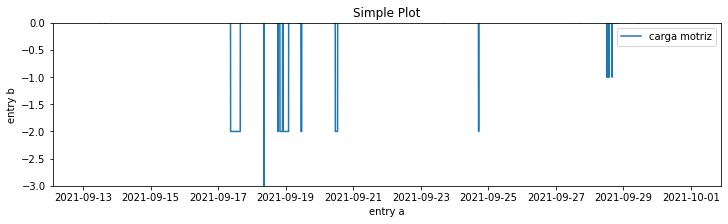

In [91]:
#https://matplotlib.org/stable/tutorials/introductory/usage.html#sphx-glr-tutorials-introductory-usage-py
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 3), layout='constrained')
ax.plot('timestamp', 'carga_motriz', data=df_rt, label='carga motriz')
ax.set_xlabel('entry a')
ax.set_ylabel('entry b')
plt.title("Simple Plot")
ax.legend()
ax.set_ylim(-3, 0);

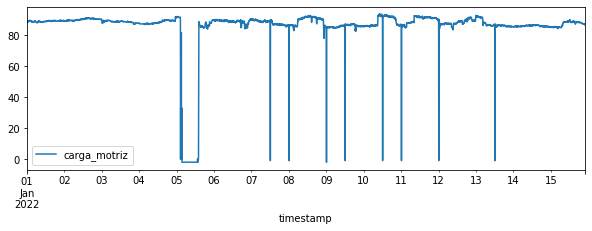

In [47]:
df_hist[(df_hist.element=='k-01') & (df_hist.timestamp>='2022-01-01') & (df_hist.timestamp<'2022-02-01')]\
    [['element', 'timestamp', 'carga_motriz']].plot(x='timestamp', figsize=(10, 3)); #, x_compat=True);

In [34]:
pd.options.display.max_colwidth = 100

In [53]:
print('cantidad de registros con mant NO prog:', df_diario[(df_diario.element=='K-09') & (df_diario.timestamp>='2021-09-01') 
            & (df_diario.mant_no_prog > 0) & (df_diario.mant_prog == 0)][['timestamp', 'comments', 'mant_prog', 'mant_no_prog']].shape)
print('cantidad de registros con mant NO prog Y paro:', df_diario[(df_diario.element=='K-09') & (df_diario.timestamp>='2021-09-01') 
            & (df_diario.mant_no_prog > 0) & (df_diario.mant_prog == 0)
            & (df_diario.comments.str.contains('paro', case=False))
         ][['timestamp', 'comments', 'mant_prog', 'mant_no_prog']].shape)

cantidad de registros con mant NO prog: (32, 4)
cantidad de registros con mant NO prog Y paro: (17, 4)


In [54]:
df_diario[(df_diario.element=='K-09') & (df_diario.timestamp>='2021-09-01') 
            & (df_diario.mant_no_prog > 0) & (df_diario.mant_prog == 0)
            & (df_diario.comments.str.contains('paro', case=False))
         ][['timestamp', 'comments', 'mant_prog', 'mant_no_prog']]

,timestamp,comments,mant_prog,mant_no_prog
23182,2021-09-13,"12:000 hs a 13:00 hs, Paro de equipo por bajas velocidad ESM.- 15:30 hs a 16:30 hs, Mtto realiza...",0.0,2.0
23187,2021-09-18,Paro de PTG ESD1. Personal de Mtto realiza cambio de filtro microspin y cambio de correas. 02:10...,0.0,10.5
23188,2021-09-19,"09:00 a 11:35 hs, Personal de Mtto realiza chequeo de equipo por Paro ESD Baja velocidad ESM. Se...",0.0,2.6
23196,2021-09-27,"11:30 a 11:45 hs, Paro por habilitación de Módulo desde Sistema. 17:00 a 18:00 hs, Personal de M...",0.0,1.3
23197,2021-09-28,"13:15 a 15:40 hs, Personal de Mtto trabaja en cambio de juntas en válvulas de Cil. Comp. #1 y #3...",0.0,5.6
23215,2021-10-16,De 12:20hs a 14:50hs Paro por alta temperatura descarga cilindro compresor #2 y #4.,0.0,2.5
23246,2021-11-16,"15:30 hs a 16:00 hs, Paro por cierre de valvula gas combustible.-",0.0,0.5
23248,2021-11-18,"K-09, 13:00hs a 17:30hs, paro por falla de comunicación,trabaja Grupo Sat en chequeo de alarmas,...",0.0,4.5
23267,2021-12-07,K-09 Hs.15:50 paro por alta presión de descarga; queda E/R. Hs.18:20 se deja E/S nuevamente.-,0.0,0.5
23274,2021-12-14,"Paro por alta presión de descarga Ci l#2 y #3, desde hs.17:40 a 18:20.-",0.0,0.6


## Base de datos con los timestamp de fallas
Se deberá MANUALMENTE indicar qué mant no programados fueron FALLAS.<BR>
Para luego "marcar" los datos de tiempo real entre estos timestamp

In [35]:
df_failure = pd.DataFrame(columns=['element', 'comments', 'timestamp_1', 'timestamp_2', 'timestamp_3', 'timestamp_4'
                                  , 'timestamp_5', 'timestamp_6'])
fail_index = 0
for index, row in df_diario[df_diario.timestamp > '2021-09-01'].iterrows():
    if row.mant_no_prog > 0 and 'paro' in row.comments.lower():
        #print(row.timestamp, row.comments)
        all_matches = re.findall(r'\d{2}:\d{2}', row.comments)
        if len(all_matches) > 0:
            row_failure = [row.element, row.comments]
            for i in range(0, max(len(all_matches), 6)):
                if i < len(all_matches):
                    row_failure.append(pd.to_datetime(row.timestamp.date().strftime('%Y-%m-%d') 
                                                      + ' ' + all_matches[i] + ':00'))
                else:
                    row_failure.append(np.NaN)
            df_failure.loc[fail_index] = row_failure
            fail_index +=1

for i in range(1,7):
    col = 'timestamp_' + str(i)
    df_failure[col] = pd.to_datetime(df_failure[col], format='%Y-%m-%d %H:%M:%S')

In [36]:
output_file = 'failure_dataset1.csv'
df_failure.to_csv(path_data + '\\' + output_file, sep=';', encoding='latin-1', decimal = '.') #   'windows-1251' 'UTF-8'

## Análisis de Datos de Falla

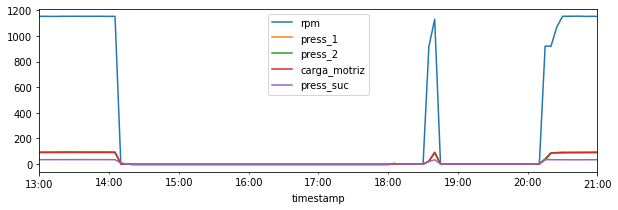

In [42]:
# K-01 26/10/2021 14:10 a 18:10 hs,  MPR - 6000HS, cambio de filtros, aceite, cambio de correas, papel microspin y chequeo de 
# botadores. 18:50 a 20:15 hs, Paro por Muy alta t° cojinete N°4 motor. 
# Se chequea y se observa pérdida de aceite en junta dresser. Personal de Mtto realiza reparación de pérdida.
# NOTA BD FALLAS: sólo el segundo período debe marcarse como falla.
df_hist[(df_hist.element=='k-01') & (df_hist.timestamp.between('2021-10-26 13:00:00', '2021-10-26 21:00:00'))]\
    [['element', 'timestamp', 'rpm', 'press_1', 'press_2', 'carga_motriz', 'press_suc']].plot(x='timestamp', figsize=(10, 3));

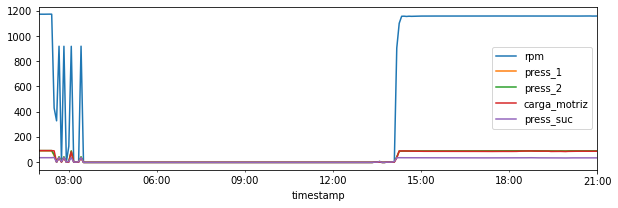

In [46]:
# K-01 4/1/2022 02:30 hs Paro por Alta t° cojinete 4 motor. Se intentan arranques con resultado negativo por baja presión 
# aceite compresor. Mtto encuentra bomba de circuito auxiliar F/S.
# NOTA BD FALLAS: Corresponde al 5/1/2022 no al 4/1 como se registró en Zafiro:
df_hist[(df_hist.element=='k-01') & (df_hist.timestamp.between('2022-01-05 02:00:00', '2022-01-05 21:00:00'))]\
    [['element', 'timestamp', 'rpm', 'press_1', 'press_2', 'carga_motriz', 'press_suc']].plot(x='timestamp', figsize=(10, 3));

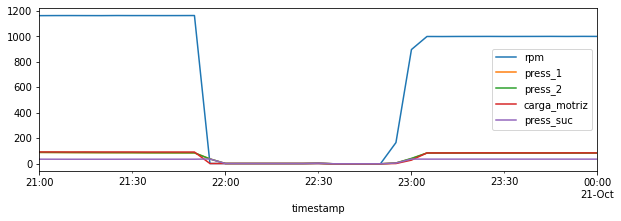

In [49]:
# K-02 21:55 hs a 23:05 hs Paro por bajo nivel de aceite motor, Mto chequea kemco se encuentra cable pelado y tornillo suelto 
# dentro de caja Aceite.- 
df_hist[(df_hist.element=='k-02') & (df_hist.timestamp.between('2021-10-20 21:00:00', '2021-10-21 00:00:00'))]\
    [['element', 'timestamp', 'rpm', 'press_1', 'press_2', 'carga_motriz', 'press_suc']].plot(x='timestamp', figsize=(10, 3));

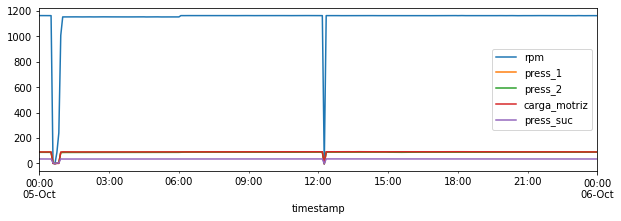

In [51]:
# K-03 4/10/2021 00:35hs a 00:50hs, Paro de emergencia remoto, E/S nuevamente.
# BD FALLAS: corresponde al 05/10/2021
df_hist[(df_hist.element=='k-03') & (df_hist.timestamp.between('2021-10-05 00:00:00', '2021-10-06 00:00:00'))]\
    [['element', 'timestamp', 'rpm', 'press_1', 'press_2', 'carga_motriz', 'press_suc']].plot(x='timestamp', figsize=(10, 3));

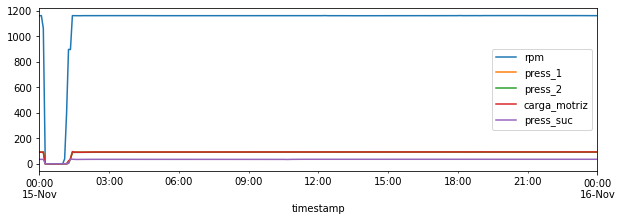

In [54]:
# K-03 14/11/2021 00:00 a 01:00 hs Se paro equipo para reemplazar tubing de refrigeracion.
# BD FALLAS: corresponde al 15/11
df_hist[(df_hist.element=='k-03') & (df_hist.timestamp.between('2021-11-15 00:00:00', '2021-11-16 00:00:00'))]\
    [['element', 'timestamp', 'rpm', 'press_1', 'press_2', 'carga_motriz', 'press_suc']].plot(x='timestamp', figsize=(10, 3));

,element,timestamp,rpm,press_1,press_2,carga_motriz,press_suc
101146,k-03,2021-11-16 15:00:00,1161.8,90.5,89.3,93.2,35.1
101147,k-03,2021-11-16 15:05:00,1162.3,90.5,89.3,93.2,35.1
101148,k-03,2021-11-16 15:10:00,1161.6,90.5,89.3,93.5,35.1
101149,k-03,2021-11-16 15:15:00,1161.8,90.5,89.3,93.2,35.1
101150,k-03,2021-11-16 15:20:00,1161.6,90.5,89.3,93.2,35.3
101151,k-03,2021-11-16 15:25:00,1162.0,90.5,89.5,93.3,35.3
101152,k-03,2021-11-16 15:30:00,0.0,0.0,0.0,0.0,0.5
101153,k-03,2021-11-16 15:35:00,0.0,0.0,0.0,0.0,0.3
101154,k-03,2021-11-16 15:40:00,0.0,0.0,0.0,0.0,0.3
101155,k-03,2021-11-16 15:45:00,0.0,0.6,0.4,0.0,1.4


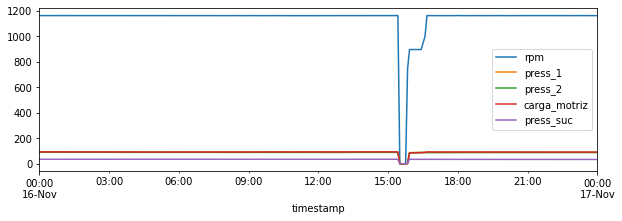

In [56]:
# K-03 16/11/2021 15:30 hs a 16 hs, Paro de equipo por bajo nivel de aceite compresor, E/S nuevamente.-  
df_hist[(df_hist.element=='k-03') & (df_hist.timestamp.between('2021-11-16 00:00:00', '2021-11-17 00:00:00'))]\
    [['element', 'timestamp', 'rpm', 'press_1', 'press_2', 'carga_motriz', 'press_suc']].plot(x='timestamp', figsize=(10, 3));
df_hist[(df_hist.element=='k-03') & (df_hist.timestamp.between('2021-11-16 15:00:00', '2021-11-16 16:00:00'))]\
    [['element', 'timestamp', 'rpm', 'press_1', 'press_2', 'carga_motriz', 'press_suc']]

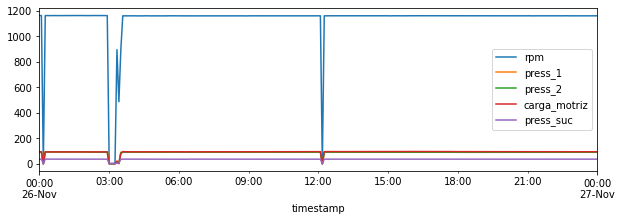

In [59]:
# K-03 25/11/2021 03:00 hs a 03:30 hs, Paro por Parada Emergencia Local.- 
# BD FALLAS: corresponde al 26/11
df_hist[(df_hist.element=='k-03') & (df_hist.timestamp.between('2021-11-26 00:00:00', '2021-11-27 00:00:00'))]\
    [['element', 'timestamp', 'rpm', 'press_1', 'press_2', 'carga_motriz', 'press_suc']].plot(x='timestamp', figsize=(10, 3));

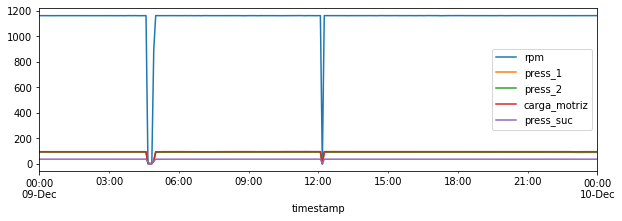

In [61]:
# K-03 8/12/2021  De 04:35hs a 04:55hs Paro por bajo nivel de aceite de compresor.
# BD FALLAS: corresponde al 9/12
df_hist[(df_hist.element=='k-03') & (df_hist.timestamp.between('2021-12-09 00:00:00', '2021-12-10 00:00:00'))]\
    [['element', 'timestamp', 'rpm', 'press_1', 'press_2', 'carga_motriz', 'press_suc']].plot(x='timestamp', figsize=(10, 3));

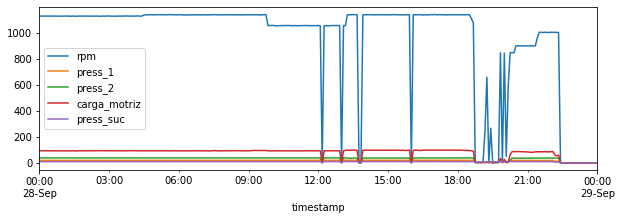

In [67]:
# K-04 28/09/2021 18:45 a 20:10 hs, Paro por Muy alto nivel de scrubber SC-1, y Falla de cierre Válvula de Recirculación. 
# 22:20 a 00:15 hs, Personal de Mtto trabaja en limpieza de filtro de succión por obturación. 
df_hist[(df_hist.element=='k-04') & (df_hist.timestamp.between('2021-09-28 00:00:00', '2021-09-29 00:00:00'))]\
    [['element', 'timestamp', 'rpm', 'press_1', 'press_2', 'carga_motriz', 'press_suc']].plot(x='timestamp', figsize=(10, 3));

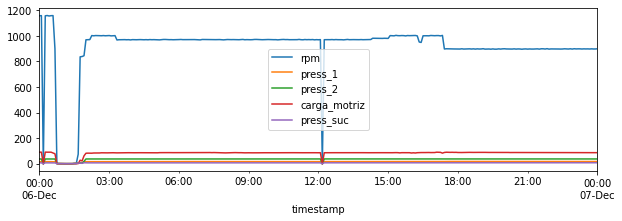

In [70]:
# K-04 05/12/2021 Paro hs. 00:45 a 02:00 Intervención de mtto. Mecánico en limpieza cono de bruja succión equipo.-
# Corresponde al 06/12
df_hist[(df_hist.element=='k-04') & (df_hist.timestamp.between('2021-12-06 00:00:00', '2021-12-07 00:00:00'))]\
    [['element', 'timestamp', 'rpm', 'press_1', 'press_2', 'carga_motriz', 'press_suc']].plot(x='timestamp', figsize=(10, 3));

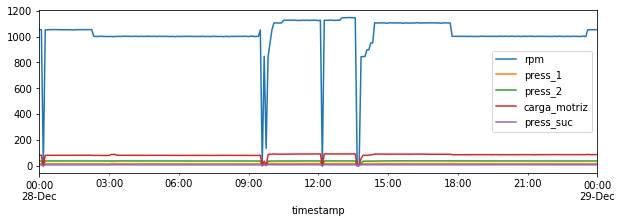

In [73]:
# K-04 28/12/2021 De 13:35hs a 13:50hs Paro por alto nivel de scrubber SC-2 el cual era falso.(????)
df_hist[(df_hist.element=='k-04') & (df_hist.timestamp.between('2021-12-28 00:00:00', '2021-12-29 00:00:00'))]\
    [['element', 'timestamp', 'rpm', 'press_1', 'press_2', 'carga_motriz', 'press_suc']].plot(x='timestamp', figsize=(10, 3));

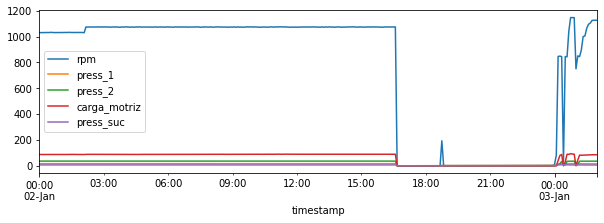

In [75]:
# K-04 2/01/2022 16:30hs, paro por falla en alcanzar RPM de marcha, se intenta arrancar con resultados negativos. 
# 00:20E/S equipo por variacion de presion diferencial de K-07.
df_hist[(df_hist.element=='k-04') & (df_hist.timestamp.between('2022-01-02 00:00:00', '2022-01-03 02:00:00'))]\
    [['element', 'timestamp', 'rpm', 'press_1', 'press_2', 'carga_motriz', 'press_suc']].plot(x='timestamp', figsize=(10, 3));

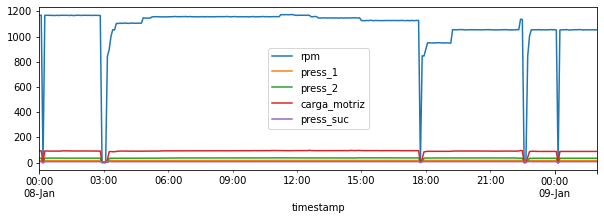

In [77]:
# K-04 7/01/2022 02:55 hs a 03:10 hs Paro por muy alta vibración en ventilado motor.-
# DB FALLAS: corresponde al 8/1
df_hist[(df_hist.element=='k-04') & (df_hist.timestamp.between('2022-01-08 00:00:00', '2022-01-09 02:00:00'))]\
    [['element', 'timestamp', 'rpm', 'press_1', 'press_2', 'carga_motriz', 'press_suc']].plot(x='timestamp', figsize=(10, 3));

,element,timestamp,rpm,press_1,press_2,carga_motriz,press_suc
100678,k-03,2021-11-15 00:00:00,1161.4,92.3,91.3,90.2,34.7
100679,k-03,2021-11-15 00:05:00,1161.8,92.3,91.3,90.6,34.7
100680,k-03,2021-11-15 00:10:00,1061.1,92.0,91.1,91.6,34.7
100681,k-03,2021-11-15 00:15:00,0.0,0.0,0.0,0.0,0.5
100682,k-03,2021-11-15 00:20:00,0.0,0.0,0.0,0.0,0.0
100683,k-03,2021-11-15 00:25:00,0.0,0.0,0.0,0.0,0.0
100684,k-03,2021-11-15 00:30:00,0.0,0.0,0.0,0.0,0.0
100685,k-03,2021-11-15 00:35:00,0.0,0.0,0.0,0.0,0.0
100686,k-03,2021-11-15 00:40:00,0.0,0.0,0.0,0.0,0.0
100687,k-03,2021-11-15 00:45:00,0.0,0.0,0.0,0.0,0.0


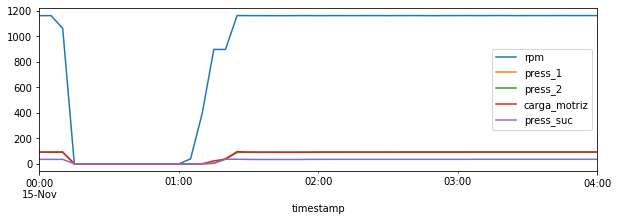

In [229]:
# 02:30 hs Paro por Alta tÂ° cojinete 4 motor. Se intentan arranques con resultado negativo por baja presiÃ³n aceite compresor. Mtto encuentra bomba de circuito auxiliar F/S.
df_slice = df_hist[(df_hist.element=='k-03') & (df_hist.timestamp.between('2021-11-15 00:00:00', '2021-11-15 04:00:00'))]\
    [['element', 'timestamp', 'rpm', 'press_1', 'press_2', 'carga_motriz', 'press_suc']]
df_slice.plot(x='timestamp', figsize=(10, 3));
df_slice

In [204]:
df_failure.isna().any()

element        False
comments       False
timestamp_1    False
timestamp_2     True
timestamp_3     True
timestamp_4     True
timestamp_5     True
timestamp_6     True
dtype: bool